In [128]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import time

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
import collections


# Other Libraries
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('D:/WorkSample/FraudDetetcion/creditcard.csv')

# Step1: Data quality Check

In [49]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [50]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Text(0, 0.5, 'Amount of data')

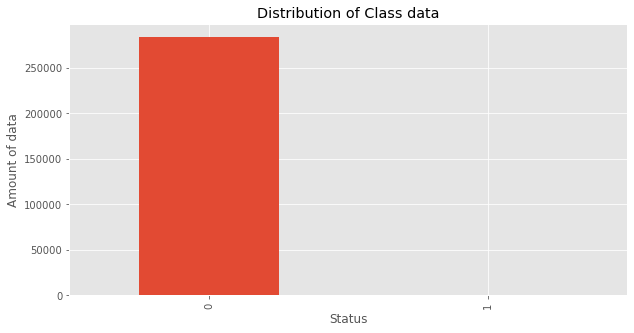

In [51]:
plt.style.use('ggplot')
fig= plt.subplots( 1, 1, figsize= (10, 5))
count_classes = df['Class'].value_counts()
count_classes.plot(kind='bar')
plt.title ("Distribution of Class data")
plt.xlabel ("Status")
plt.ylabel ("Amount of data")

In [129]:
df_temp = df
df_temp['Hour'] = df_temp['Time'].apply(lambda x: np.floor(x / 3600))

tmp = df_temp.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df_temp = pd.DataFrame(tmp)
df_temp.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']

The figure below shows the amount trend of both non-fraud and fraud data

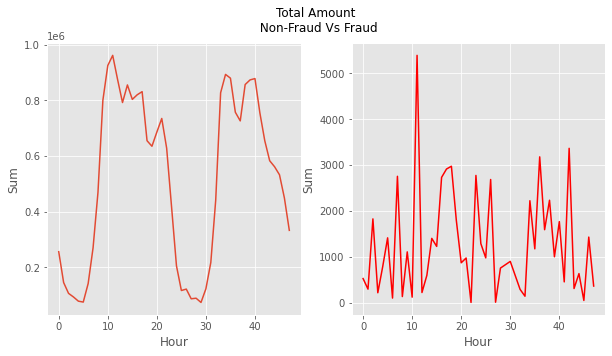

In [53]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df_temp.loc[df_temp.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df_temp.loc[df_temp.Class==1], color="red")
plt.suptitle("Total Amount \n Non-Fraud Vs Fraud")
plt.show()

The figure below shows the transaction trend of both non-fraud and fraud data

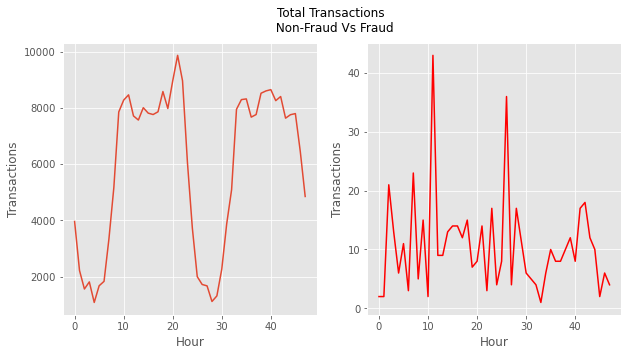

In [54]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df_temp.loc[df_temp.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df_temp.loc[df_temp.Class==1], color="red")
plt.suptitle("Total Transactions \n Non-Fraud Vs Fraud")
plt.show()

The following figure shows one interesting result: the fraud transaction amount can't be too much. I think the reason is that when fraud transaction number is higher than 2000, the bank will interupt the trancation and verify the fraud. 

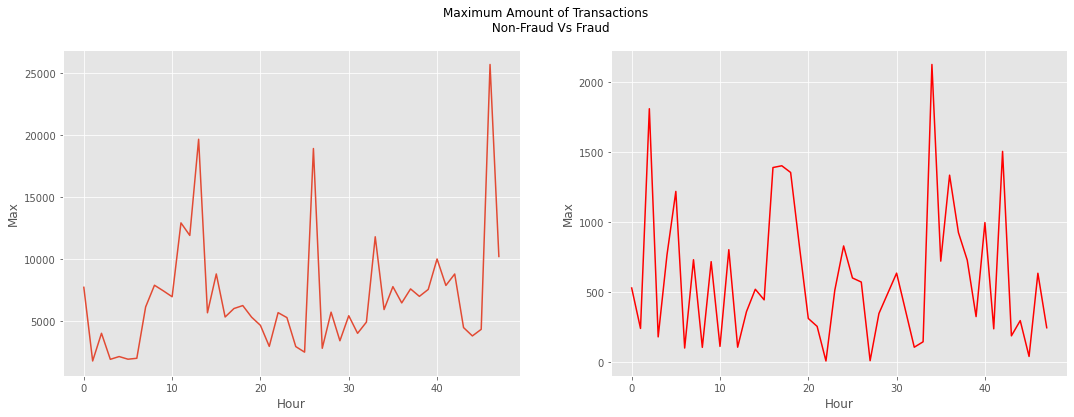

In [55]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df_temp.loc[df_temp.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df_temp.loc[df_temp.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions  \n Non-Fraud Vs Fraud")
plt.show()

The following figure is the box plot for Non-fraud and fraud transactions. 

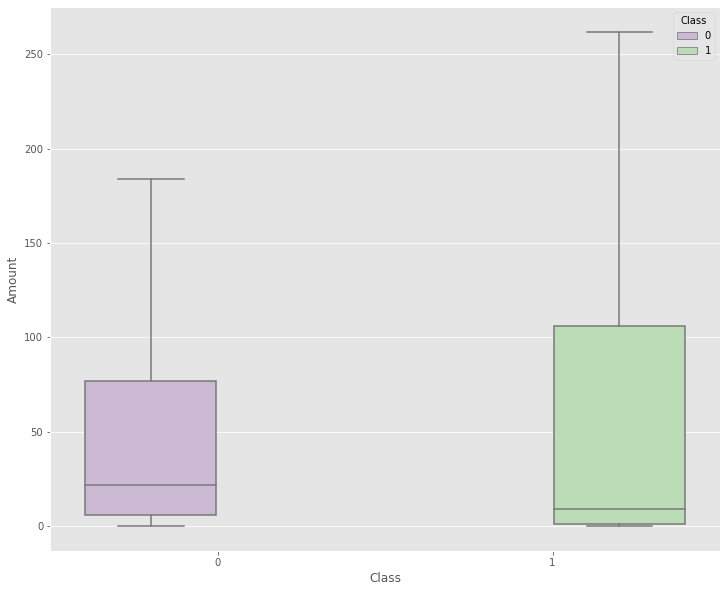

In [56]:
fig = plt.subplots(ncols=1, figsize=(12,10))
s = sns.boxplot(x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=False)
plt.show();

The following figure uses scatter plot to show the amount distribution of fraud transaction over time.

In [57]:
fraud = df.loc[df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

# Step 2: Scale and fix imbalance data

#### Scale Time

In [130]:
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Hour'], axis=1, inplace=True)

In [131]:
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-0.994960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,1.034951
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,1.034963
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,1.034975
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,1.034975


#### Under-sample our dataset

In [132]:
df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
rus_df = normal_distributed_df.sample(frac=1, random_state=42)
rus_df['Class'].value_counts()

0    492
1    492
Name: Class, dtype: int64

In [133]:
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_time
76558,-0.925533,1.366015,0.840533,0.605088,0.504173,-0.090662,0.624767,-0.058012,-0.611246,0.009898,...,0.166768,-0.194843,-0.617479,-0.070409,-0.419488,-0.521962,-0.118479,12.79,0,-0.329727
161926,-0.934539,0.119791,1.668306,-0.871624,1.212645,2.122258,-0.372997,0.871473,0.375663,-0.986645,...,0.314734,-0.076684,-0.695162,0.011319,0.549041,0.071931,-0.198339,14.63,0,0.351978
97076,1.311258,0.075028,-1.292832,-0.483154,2.139257,3.181564,-0.505045,0.804860,-0.074071,-0.217426,...,-1.148504,0.095279,0.946121,0.369713,0.110626,-0.021837,0.023638,1.98,0,-0.218847
196184,-1.654376,0.499877,0.251450,-1.179917,-0.714720,0.534450,-0.368503,-1.090054,-0.746091,0.174597,...,-1.701666,-0.057098,-0.415973,-0.212935,0.302844,0.346362,-0.040270,96.60,0,0.548667
57519,0.974693,0.129112,0.957227,2.589493,-0.604731,-0.269016,-0.104192,-0.027208,-0.451461,0.629985,...,0.338345,-0.142768,0.400583,0.397333,0.086649,-0.006143,0.046759,102.69,0,-0.431737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9439,1.240619,0.362429,0.318717,0.709700,-0.137192,-0.529381,-0.161678,-0.078648,1.180004,-0.464205,...,-1.017629,0.096693,-0.116015,0.184709,0.061004,-0.058206,0.009350,0.99,0,-0.831495
119727,0.993579,-0.085038,0.141444,1.229070,-0.444451,-0.933653,0.355702,-0.237960,0.044762,-0.030321,...,0.016555,-0.206953,0.390601,0.622654,-0.340547,-0.014085,0.041834,133.94,0,-0.107297
169131,-0.388946,0.581329,-0.046600,-0.622632,-1.186146,0.253694,2.195382,-0.420048,-0.430686,-0.334696,...,-0.202195,0.094602,0.094938,-0.927431,1.072936,0.006912,0.048721,322.05,0,0.409474
275563,-0.978769,0.677084,0.598108,-1.910219,0.192574,-0.513438,0.338590,-0.151036,-0.914948,-0.083320,...,-1.229334,-0.123240,0.524442,0.396570,-0.600765,-0.335727,0.086970,32.37,0,0.962288


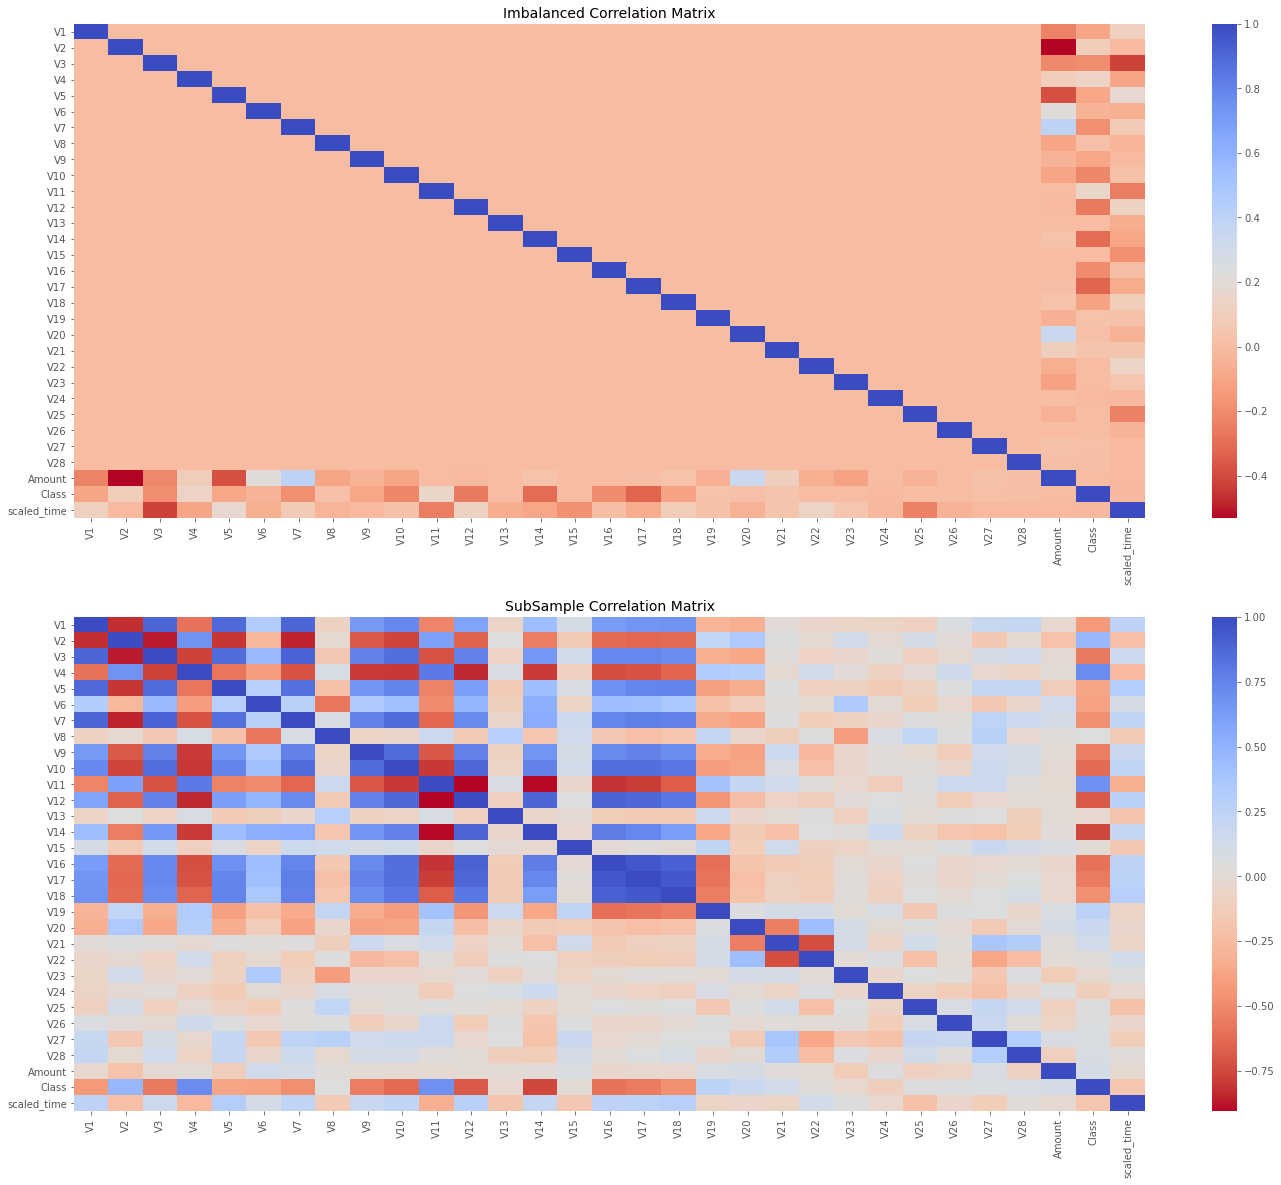

In [134]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix", fontsize=14)


sub_sample_corr = rus_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix', fontsize=14)
plt.show()

You can see that V2, V4, V11, V19 are positively correlated with class. V3, V7, V9, V10, V12, V14, V16, V17 are negatively correlated with class. 

# Step 2: Classifiers with under-sampled dataset

#### Feed dataset to classifiers

In [136]:
X = rus_df.drop('Class', axis=1)
y = rus_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Logistic Regression

In [137]:
lr = LogisticRegression(penalty='l2', class_weight = {1:4,0:1}, C=0.01 , max_iter=200, random_state=15)
lr.fit(X_train, y_train)
lr_pred_rus = lr.predict(X_test)

rus_lr_recall = recall_score(y_test, lr_pred_rus)
rus_lr_precision = precision_score(y_test, lr_pred_rus)
rus_lr_accuracy = accuracy_score(y_test, lr_pred_rus)
rus_lr_f1 = f1_score(y_test, lr_pred_rus)
rus_lr_auc = roc_auc_score(y_test, lr_pred_rus)

print(f'For the Logistic Regression, we got:')
print(f'recall: {rus_lr_recall}')
print(f'precison: {rus_lr_precision}')
print(f'accuracy: {rus_lr_accuracy}')
print(f'F1-Score: {rus_lr_f1}')
print(f'AUC-Score: {rus_lr_auc}')

For the Logistic Regression, we got:
recall: 0.9506172839506173
precison: 0.9166666666666666
accuracy: 0.9256756756756757
F1-Score: 0.9333333333333332
AUC-Score: 0.9230698360051595


In [138]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='precision',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.973907 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}


#### KNN

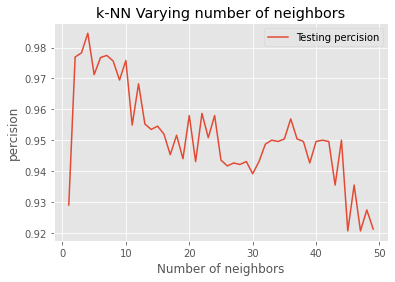

Wall time: 1.54 s


In [139]:
%%time
neighbors = np.arange(1,50)
test_percision = np.empty(len(neighbors))

plt.style.use('ggplot')

for i,k in enumerate(neighbors):
    rus_knn = KNeighborsClassifier(n_neighbors=k)
    rus_knn.fit(X_train, y_train)
    y_pred_knn = rus_knn.predict(X_test)
    
    test_percision[i] = precision_score(y_test, y_pred_knn) 
 
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_percision, label='Testing percision')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('percision')
plt.show()

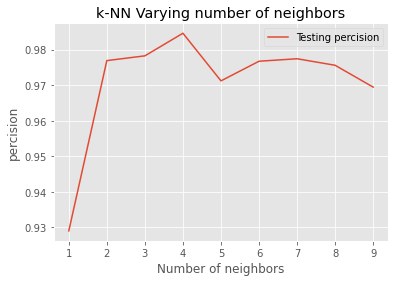

Wall time: 389 ms


In [140]:
%%time
neighbors = np.arange(1,10)
test_percision = np.empty(len(neighbors))

plt.style.use('ggplot')

for i,k in enumerate(neighbors):
    rus_knn = KNeighborsClassifier(n_neighbors=k)
    rus_knn.fit(X_train, y_train)
    y_pred_knn = rus_knn.predict(X_test)
    
    test_percision[i] = precision_score(y_test, y_pred_knn) 
 
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_percision, label='Testing percision')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('percision')
plt.show()

In [141]:
rus_knn = KNeighborsClassifier(n_neighbors=2)
rus_knn.fit(X_train, y_train)
y_pred_knn = rus_knn.predict(X_test)

rus_knn_recall = recall_score(y_test, y_pred_knn)
rus_knn_precision = precision_score(y_test, y_pred_knn)
rus_knn_accuracy = accuracy_score(y_test, y_pred_knn)
rus_knn_f1 = f1_score(y_test, y_pred_knn)

print(f'For the KNN, we got:')
print(f'recall: {rus_knn_recall}')
print(f'precison: {rus_knn_precision}')
print(f'accuracy: {rus_knn_accuracy}')
print(f'F1-Score: {rus_knn_f1}')

For the KNN, we got:
recall: 0.7839506172839507
precison: 0.9769230769230769
accuracy: 0.8716216216216216
F1-Score: 0.8698630136986302


#### Random Forest

In [142]:
rus_rfc = RandomForestClassifier() 
rus_rfc.fit(X_train, y_train) 
y_pred_rf = rus_rfc.predict(X_test)

rus_rf_recall = recall_score(y_test, y_pred_rf)
rus_rf_precision = precision_score(y_test, y_pred_rf)
rus_rf_accuracy = accuracy_score(y_test, y_pred_rf)
rus_rf_f1 = f1_score(y_test, y_pred_rf)

print(f'For the RF, we got:')
print(f'recall: {rus_rf_recall}')
print(f'precison: {rus_rf_precision}')
print(f'accuracy: {rus_rf_accuracy}')
print(f'F1-Score: {rus_rf_f1}')

For the RF, we got:
recall: 0.9197530864197531
precison: 0.9738562091503268
accuracy: 0.9425675675675675
F1-Score: 0.946031746031746


#### ROC Curves for three models

In [143]:
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_pred_rus)
knn_fpr, knn_tpr, _ = roc_curve(y_test, y_pred_knn)
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_pred_rf)

rus_lr_auc = roc_auc_score(y_test, lr_pred_rus)
rus_knn_auc = roc_auc_score(y_test, y_pred_knn)
rus_rf_auc = roc_auc_score(y_test, y_pred_rf)

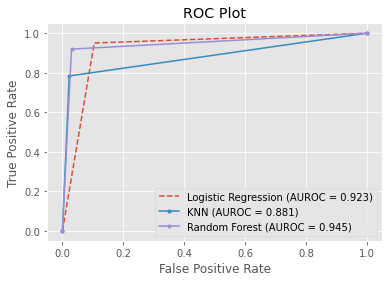

In [144]:
plt.plot(lr_fpr, lr_tpr, linestyle='--', label='Logistic Regression (AUROC = %0.3f)' % rus_lr_auc)
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN (AUROC = %0.3f)' % rus_knn_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rus_rf_auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

# Step 3: Classifiers with Random Over-sampled dataset

In [145]:
from imblearn.over_sampling import RandomOverSampler

In [146]:
y = df['Class']
x = df.drop(['Class'], axis=1).values

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                  test_size=0.25, random_state=44, stratify=y)

from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [147]:
oversample = RandomOverSampler(sampling_strategy='minority', random_state=1)
X_train, y_train = oversample.fit_resample(x_train, y_train)
y_train.value_counts()

0    213236
1    213236
Name: Class, dtype: int64

#### KNN

In [148]:
knn = KNeighborsClassifier(n_neighbors=5, 
                           weights = "distance")
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(x_test)

knn_recall = recall_score(y_test, y_pred_knn)
knn_precision = precision_score(y_test, y_pred_knn)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn)

print(f'For the RF, we got:')
print(f'recall: {knn_recall}')
print(f'precison: {knn_precision}')
print(f'accuracy: {knn_accuracy}')
print(f'F1-Score: {knn_f1}')

For the RF, we got:
recall: 0.8617886178861789
precison: 0.7210884353741497
accuracy: 0.9991854161399961
F1-Score: 0.7851851851851853


#### Random Forest

In [149]:
ros_rfc = RandomForestClassifier() 
ros_rfc.fit(X_train, y_train) 
y_pred_ros = ros_rfc.predict(x_test)

rf_recall = recall_score(y_test, y_pred_ros)
rf_precision = precision_score(y_test, y_pred_ros)
rf_accuracy = accuracy_score(y_test, y_pred_ros)
rf_f1 = f1_score(y_test, y_pred_ros)

print(f'For the RF, we got:')
print(f'recall: {rf_recall}')
print(f'precison: {rf_precision}')
print(f'accuracy: {rf_accuracy}')
print(f'F1-Score: {rf_f1}')

For the RF, we got:
recall: 0.8536585365853658
precison: 0.9292035398230089
accuracy: 0.9996348417179293
F1-Score: 0.8898305084745762


#### ROC Curves for two models

In [150]:
ros_knn_fpr, ros_knn_tpr, _ = roc_curve(y_test, y_pred_knn)
ros_rf_fpr, ros_rf_tpr, _ = roc_curve(y_test, y_pred_ros)

rus_knn_auc = roc_auc_score(y_test, y_pred_knn)
rus_rf_auc = roc_auc_score(y_test, y_pred_ros)

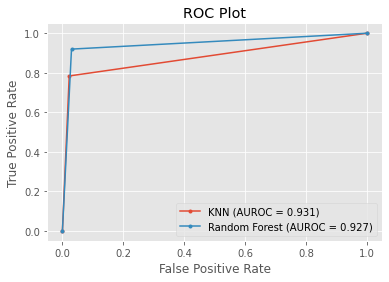

In [151]:
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN (AUROC = %0.3f)' % rus_knn_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rus_rf_auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

# Extra Step 1: Use feature selection to improve the model performance

In [152]:
df = pd.read_csv('D:/WorkSample/FraudDetetcion/creditcard.csv')

rob_scaler = RobustScaler()

#df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

#df.drop(['Time','Amount'], axis=1, inplace=True)
df.drop(['Time'], axis=1, inplace=True)

#scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

#df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.drop(['scaled_time'], axis=1, inplace=True)
#df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

#-----------------------------------------------------------

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
rus_df_p4 = normal_distributed_df.sample(frac=1, random_state=42)
rus_df_p4['Class'].value_counts()

0    492
1    492
Name: Class, dtype: int64

In [153]:
new_rus_df = rus_df_p4[['V1','scaled_time','V2','V3','V4','V7','V9','V10','V11','V12','V14','V16','V17','V18','V19','Class']]

X1 = new_rus_df.drop('Class', axis=1)
y1 = new_rus_df['Class']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

#### Logistic Regressionn

In [154]:
lr = LogisticRegression(penalty='l2', class_weight = {1:4,0:1}, C=0.01 , max_iter=200, random_state=15)
lr.fit(X1_train, y1_train)
lr_pred_rus = lr.predict(X1_test)

rus_lr_recall = recall_score(y1_test, lr_pred_rus)
rus_lr_precision = precision_score(y1_test, lr_pred_rus)
rus_lr_accuracy = accuracy_score(y1_test, lr_pred_rus)
rus_lr_f1 = f1_score(y1_test, lr_pred_rus)
rus_lr_auc = roc_auc_score(y1_test, lr_pred_rus)

print(f'For the Logistic Regression, we got:')
print(f'recall: {rus_lr_recall}')
print(f'precison: {rus_lr_precision}')
print(f'accuracy: {rus_lr_accuracy}')
print(f'F1-Score: {rus_lr_f1}')
print(f'AUC-Score: {rus_lr_auc}')

For the Logistic Regression, we got:
recall: 0.9382716049382716
precison: 0.9620253164556962
accuracy: 0.9459459459459459
F1-Score: 0.95
AUC-Score: 0.9467477427676433


In [155]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='precision',error_score=0)
grid_result = grid_search.fit(X1_train, y1_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.985075 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}


#### Random Forest

In [156]:
rus_rfc = RandomForestClassifier() 
rus_rfc.fit(X1_train, y1_train) 
y_pred_rf = rus_rfc.predict(X1_test)

rus_rf_recall = recall_score(y1_test, y_pred_rf)
rus_rf_precision = precision_score(y1_test, y_pred_rf)
rus_rf_accuracy = accuracy_score(y1_test, y_pred_rf)
rus_rf_f1 = f1_score(y1_test, y_pred_rf)

print(f'For the RF, we got:')
print(f'recall: {rus_rf_recall}')
print(f'precison: {rus_rf_precision}')
print(f'accuracy: {rus_rf_accuracy}')
print(f'F1-Score: {rus_rf_f1}')

For the RF, we got:
recall: 0.9074074074074074
precison: 0.98
accuracy: 0.9391891891891891
F1-Score: 0.9423076923076924


In [157]:
lr_fpr, lr_tpr, _ = roc_curve(y1_test, lr_pred_rus)
rf_fpr, rf_tpr, _ = roc_curve(y1_test, y_pred_rf)

rus_lr_auc = roc_auc_score(y1_test, lr_pred_rus)
rus_rf_auc = roc_auc_score(y1_test, y_pred_rf)

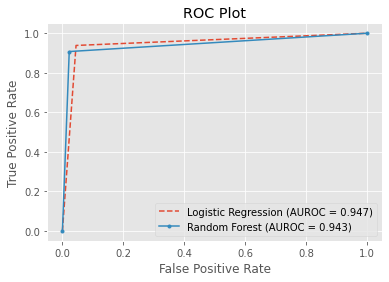

In [158]:
plt.plot(lr_fpr, lr_tpr, linestyle='--', label='Logistic Regression (AUROC = %0.3f)' % rus_lr_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rus_rf_auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

# Extra Step 2: Performance comparance with scaling both time and amount

In [162]:
df_e2 = pd.read_csv('D:/WorkSample/FraudDetetcion/creditcard.csv')
df_e2

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [163]:
rob_scaler = RobustScaler()

df_e2['scaled_amount'] = rob_scaler.fit_transform(df_e2['Amount'].values.reshape(-1,1))
df_e2['scaled_time'] = rob_scaler.fit_transform(df_e2['Time'].values.reshape(-1,1))

scaled_amount = df_e2['scaled_amount']
scaled_time = df_e2['scaled_time']

df_e2.drop(['Time', 'Amount'], axis=1, inplace=True)

In [164]:
df_e2 = df_e2.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df_e2.loc[df_e2['Class'] == 1]
non_fraud_df = df_e2.loc[df_e2['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
rus_df_p5 = normal_distributed_df.sample(frac=1, random_state=42)
rus_df_p5['Class'].value_counts()

0    492
1    492
Name: Class, dtype: int64

In [165]:
new_rus_df_e2 = rus_df_p5[['V1','scaled_time','V2','V3','V4','V7','V9','V10','V11','V12','V14','V16','V17','V18','V19','Class']]

X2 = new_rus_df_e2.drop('Class', axis=1)
y2 = new_rus_df_e2['Class']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

In [166]:
lr_e2 = LogisticRegression(penalty='l2', class_weight = {1:4,0:1}, C=0.01 , max_iter=200, random_state=15)
lr_e2.fit(X2_train, y2_train)
lr_pred_rus_e2 = lr_e2.predict(X2_test)

rus_lr_recall = recall_score(y2_test, lr_pred_rus_e2)
rus_lr_precision = precision_score(y2_test, lr_pred_rus_e2)
rus_lr_accuracy = accuracy_score(y2_test, lr_pred_rus_e2)
rus_lr_f1 = f1_score(y2_test, lr_pred_rus_e2)
rus_lr_auc = roc_auc_score(y2_test, lr_pred_rus_e2)

print(f'For the Logistic Regression, we got:')
print(f'recall: {rus_lr_recall}')
print(f'precison: {rus_lr_precision}')
print(f'accuracy: {rus_lr_accuracy}')
print(f'F1-Score: {rus_lr_f1}')
print(f'AUC-Score: {rus_lr_auc}')

For the Logistic Regression, we got:
recall: 0.9197530864197531
precison: 0.9141104294478528
accuracy: 0.9087837837837838
F1-Score: 0.9169230769230768
AUC-Score: 0.9076377372397274


In [167]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='precision',error_score=0)
grid_result = grid_search.fit(X2_train, y2_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.987050 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}


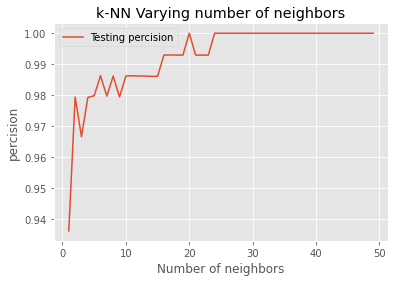

Wall time: 748 ms


In [168]:
%%time
neighbors = np.arange(1,50)
test_percision = np.empty(len(neighbors))

plt.style.use('ggplot')

for i,k in enumerate(neighbors):
    rus_knn = KNeighborsClassifier(n_neighbors=k)
    rus_knn.fit(X2_train, y2_train)
    y_pred_knn = rus_knn.predict(X2_test)
    
    test_percision[i] = precision_score(y2_test, y_pred_knn) 
 
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_percision, label='Testing percision')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('percision')
plt.show()

In [169]:
rus_knn_e2 = KNeighborsClassifier(n_neighbors=20)
rus_knn_e2.fit(X2_train, y2_train)
y_pred_knn = rus_knn.predict(X2_test)

rus_knn_recall = recall_score(y2_test, y_pred_knn)
rus_knn_precision = precision_score(y2_test, y_pred_knn)
rus_knn_accuracy = accuracy_score(y2_test, y_pred_knn)
rus_knn_f1 = f1_score(y2_test, y_pred_knn)

print(f'For the KNN, we got:')
print(f'recall: {rus_knn_recall}')
print(f'precison: {rus_knn_precision}')
print(f'accuracy: {rus_knn_accuracy}')
print(f'F1-Score: {rus_knn_f1}')

For the KNN, we got:
recall: 0.845679012345679
precison: 1.0
accuracy: 0.9155405405405406
F1-Score: 0.9163879598662207


We can see that scaling transaction amount will reduce the performance of KNN. My assumption is that transaction amount is definitely a key component for anomoly detection, which means that scaling this feature will make the performance of our model get reduced somehow.

# Sum up

1. For this project, I used two different methods to handle the imbalanced dataset: Random Undersampling and Oversampling.
2. There are two challenges been met during the whole project:
In the first try with under-sampling, the performance of three classifier is extremely poor. The precision and recall are        all below 0.5. The reason is that the procedure of under-sample was wrong. The correct procedure should be under-sample          the origin dataset first then do the train-test spliting. But I did it in the ooposite way. When I correct the procedure, the precison for all three classifier went over 90%.
The second challenge is about parameter scaling. In the first try, I scaled both time and transaction amount. In the second try, I only scaled time. The result shows that scaling time only can bring better performance. Especially for the KNN model
3. For the future improvements, I think I can apply more advanced undersampling and oversampling methods, such as SMOTE and NEARMISS. For the model improvement, I think I can also apply unsupervised machine models, such as SVM, into this project. 

# Reference
#### 1. https://www.kaggle.com/code/gpreda/credit-card-fraud-detection-predictive-models#Data-exploration
#### 2. https://github.com/dataprofessor/code/blob/master/python/ROC_curve.ipynb
#### 3. https://www.kaggle.com/code/mustafabayhan/approach-of-oversampling-ensemble-recall-93